In [ ]:
!python3 -c "import lightning" || pip install lightning==2.2.4
!python3 -c "import torchsummary" || pip install torchsummary

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from typing import Tuple
from PIL import Image, ImageOps
from collections import OrderedDict
import seaborn as sns

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import SGD
import torch.nn.functional as TF
from torchsummary import summary
from torchvision import models
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.v2 import functional as TVF
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
from torchvision.transforms import ToTensor

import lightning.pytorch as pl
import lightning as L
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

from skimage import data, io
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, confusion_matrix, accuracy_score, precision_recall_fscore_support, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, classification_report

In [2]:
print(torch.cuda.get_arch_list())

['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_37', 'sm_90']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_08_14_objects_clean"

In [6]:
random.seed(42)

In [7]:
def pad2size(image, size=(768, 768)):
    return ImageOps.fit(image, size)

class PollenTripletDataset(Dataset):
    def __init__(self, img_dir, classes, 
                 static_transform=None, 
                 random_transform=None,
                 inflation_rate=1):
        self.known_classes = classes
        self.known_classes.sort()
        self.transform = random_transform
        self._all_samples = []
        self._indices_to_class = {}
        self._class_to_indices = {i: [] for i,c in enumerate(self.known_classes)}

        total_samples = 0
        for c in tqdm(self.known_classes):
            c_number = len(self._indices_to_class)
            self._indices_to_class[c_number] = c
            images = glob(os.path.join(img_dir, c, "*.png"))
            print(f"{len(images)} samples in the class {c}")
            
            for idx, img_path in enumerate(tqdm(images)):
                img = Image.open(img_path)
                if static_transform is not None:
                    img = static_transform(img)
                self._all_samples.append((c_number, img))
                self._class_to_indices[c_number].append(total_samples)
                total_samples += 1
        
        print(f"Total samples: {total_samples}")

    def __len__(self):
        return len(self._all_samples)

    def __getitem__(self, idx):
        label, img = self._all_samples[idx]
        label_str = self._indices_to_class[label]
        return img, label, label_str

known_classes = os.listdir(OBJECTS_ROOT)#['Alnus', 'Betula', 'Acer', 'Pinus', 'Salix', 'Tilia', 'Quercus']

print(f"All known classes: {known_classes}")
train_classes, val_classes = train_test_split(known_classes, test_size=0.2, random_state=42)
train_classes, test_classes = train_test_split(train_classes, test_size=0.2, random_state=42)

print(f"Train classes: {train_classes}")
print(f"Validation classes: {val_classes}")
print(f"Test classes: {test_classes}")

static_transforms = v2.Compose([
    v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("\nLoad Train Dataset")
dataset_train = PollenTripletDataset(OBJECTS_ROOT, train_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Validation Dataset")
dataset_val = PollenTripletDataset(OBJECTS_ROOT, val_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Test Dataset")
dataset_test = PollenTripletDataset(OBJECTS_ROOT, test_classes, static_transform=static_transforms, inflation_rate=100)

All known classes: ['Alnus', 'Betula', 'Corylus', 'Acer', 'Chenopodiaceae', 'Pinus', 'Poaceae', 'Apiaceae', 'Rumex', 'Salix', 'Populus tremula', 'Urtica', 'Artemisia', 'Picea', 'Tilia', 'Plantago', 'Quercus', 'Fraxinus']
Train classes: ['Tilia', 'Corylus', 'Chenopodiaceae', 'Quercus', 'Picea', 'Poaceae', 'Urtica', 'Fraxinus', 'Apiaceae', 'Plantago', 'Salix']
Validation classes: ['Alnus', 'Betula', 'Rumex', 'Pinus']
Test classes: ['Artemisia', 'Populus tremula', 'Acer']

Load Train Dataset


  0%|          | 0/11 [00:00<?, ?it/s]

131 samples in the class Apiaceae


  0%|          | 0/131 [00:00<?, ?it/s]

150 samples in the class Chenopodiaceae


  0%|          | 0/150 [00:00<?, ?it/s]

146 samples in the class Corylus


  0%|          | 0/146 [00:00<?, ?it/s]

186 samples in the class Fraxinus


  0%|          | 0/186 [00:00<?, ?it/s]

99 samples in the class Picea


  0%|          | 0/99 [00:00<?, ?it/s]

113 samples in the class Plantago


  0%|          | 0/113 [00:00<?, ?it/s]

52 samples in the class Poaceae


  0%|          | 0/52 [00:00<?, ?it/s]

88 samples in the class Quercus


  0%|          | 0/88 [00:00<?, ?it/s]

234 samples in the class Salix


  0%|          | 0/234 [00:00<?, ?it/s]

113 samples in the class Tilia


  0%|          | 0/113 [00:00<?, ?it/s]

42 samples in the class Urtica


  0%|          | 0/42 [00:00<?, ?it/s]

Total samples: 1354

Load Validation Dataset


  0%|          | 0/4 [00:00<?, ?it/s]

103 samples in the class Alnus


  0%|          | 0/103 [00:00<?, ?it/s]

205 samples in the class Betula


  0%|          | 0/205 [00:00<?, ?it/s]

73 samples in the class Pinus


  0%|          | 0/73 [00:00<?, ?it/s]

98 samples in the class Rumex


  0%|          | 0/98 [00:00<?, ?it/s]

Total samples: 479

Load Test Dataset


  0%|          | 0/3 [00:00<?, ?it/s]

316 samples in the class Acer


  0%|          | 0/316 [00:00<?, ?it/s]

242 samples in the class Artemisia


  0%|          | 0/242 [00:00<?, ?it/s]

210 samples in the class Populus tremula


  0%|          | 0/210 [00:00<?, ?it/s]

Total samples: 768


In [8]:
def plot(imgs, row_title=None, labels=None, **imshow_kwargs):
    if labels != None:
        ax_title = True
    else:
        ax_title = False
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = TVF.to_dtype(img, torch.uint8, scale=True)
            black_pixels = (img != 0).all(dim=0)
            img[:, ~black_pixels] = 255
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if ax_title:
                ax.set_title(labels[col_idx])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [9]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 8,
    shuffle= True,
    num_workers= 6
)
val_loader = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 8,
    shuffle= True,
    num_workers= 6
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size= 1,
    shuffle= True,
    num_workers= 6
)

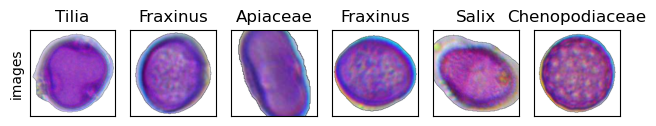

In [10]:
for images, label, name in train_loader:
    plot(images[:6], row_title=["images"], labels=name[:6])
    break

In [11]:
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [21]:
class EmbeddingModel(nn.Module):
    def __init__(self, embeddings=64):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.embeddings = nn.Linear(num_features, embeddings)

    def forward(self, x):
        x = self.model(x)
        x = self.embeddings(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x

class PollenEmbeddingsModule(L.LightningModule):
    def __init__(self, check_val=5, config={}):
        super().__init__()
        embeddings_size = 256
        self.model = EmbeddingModel(embeddings_size)
        config["backbone"]="resnet50"
        config["embeddings_size"]=embeddings_size
        config["check_val"]=check_val
        config["optim_lr"]=0.000000001
        config["optim_betas"]=(0.9, 0.999)
        config["optim_eps"]=1e-08
        config["optim_weight_decay"]=0
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters(config)

        self.loss_function = CircleLoss(m=0.7, gamma=80)
        self.best_score = 1
        self.best_val_epoch = -1

        self.train_step_outputs = []
        self.val_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        self.to(self.device)

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        img, label, _ = batch
        pred = self.model(img)
        loss = self.loss_function(*convert_label_to_similarity(pred, label))
        pred = {"train_loss": loss, "train_number": len(pred)}
        self.train_step_outputs.append(pred)
        return loss

    def on_train_epoch_end(self):
        outputs = self.train_step_outputs
        train_loss, num_items = 0, 0
        for output in outputs:
            train_loss += output["train_loss"].sum().item()
            num_items += output["train_number"]

        mean_train_loss = torch.tensor(train_loss / num_items)
        self.log("train_loss", mean_train_loss)
        self.train_losses.append(mean_train_loss.item())
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        img, label, _ = batch
        pred = self.model(img)
        loss = self.loss_function(*convert_label_to_similarity(pred, label))
        pred = {"val_loss": loss, "val_number": len(pred)}
        self.val_step_outputs.append(pred)
        return loss

    def on_validation_epoch_end(self):
        outputs = self.val_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)
        self.log("val_loss", mean_val_loss)
        self.val_losses.append(mean_val_loss.item())
        self.val_step_outputs.clear()  # free memory

        if mean_val_loss < self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot([i for i in range(len(self.train_losses))], self.train_losses, label='Train Loss')
        plt.plot([i * self.hparams.check_val for i in range(len(self.val_losses)-1)], self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

In [28]:
model = PollenEmbeddingsModule(check_val=1)

In [29]:
model = model.to(device)
summary(model.model, input_size=(3, 768, 768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           9,408
       BatchNorm2d-2         [-1, 64, 384, 384]             128
              ReLU-3         [-1, 64, 384, 384]               0
         MaxPool2d-4         [-1, 64, 192, 192]               0
            Conv2d-5         [-1, 64, 192, 192]           4,096
       BatchNorm2d-6         [-1, 64, 192, 192]             128
              ReLU-7         [-1, 64, 192, 192]               0
            Conv2d-8         [-1, 64, 192, 192]          36,864
       BatchNorm2d-9         [-1, 64, 192, 192]             128
             ReLU-10         [-1, 64, 192, 192]               0
           Conv2d-11        [-1, 256, 192, 192]          16,384
      BatchNorm2d-12        [-1, 256, 192, 192]             512
           Conv2d-13        [-1, 256, 192, 192]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [30]:
checkpoint_callback = ModelCheckpoint(
    filename='checkpoint-{epoch:02d}-{val_loss:.4f}',
    # auto_insert_metric_name=False,
    dirpath="./history",
    monitor='val_loss',
    mode='min')
lr_logger = LearningRateMonitor()
logger = CSVLogger("logs", name="triplet_1")

In [31]:
trainer = L.Trainer(logger=logger,
                    log_every_n_steps=1,  # Increase, if epoch size is large
                    callbacks=[checkpoint_callback, lr_logger],
                    precision="16-mixed",
                    check_val_every_n_epoch=model.hparams.check_val,
                    max_epochs=13,
                    accumulate_grad_batches=2,
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, 
            train_dataloaders=train_loader,
            val_dataloaders=val_loader,     
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type           | Params
-------------------------------------------------
0 | model         | EmbeddingModel | 24.0 M
1 | loss_function | CircleLoss     | 0     
-------------------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.130    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
model.plot_losses()

## Loading the model

In [19]:
checkpoint_path = "/home/jovyan/git/Pollen-Analyzer/Classification/history/checkpoint-epoch=11-val_loss=0.5668.ckpt"
loaded_model = PollenEmbeddingsModule.load_from_checkpoint(checkpoint_path)

In [20]:
loaded_model.eval()
loaded_model = loaded_model.cuda()

## Metrics and quality analysis

In [21]:
def add_class_markings(ax, class_boundaries, labels):
    tick_locs = [(class_boundaries[i] + class_boundaries[i+1] - 1) / 2 for i in range(len(class_boundaries)-1)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    ax.set_xticklabels([labels[int(loc)] for loc in tick_locs])
    ax.set_yticklabels([labels[int(loc)] for loc in tick_locs])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for boundary in class_boundaries[1:-1]:
        ax.axhline(y=boundary-1, color='k', linestyle='-', linewidth=1)
        ax.axvline(x=boundary-1, color='k', linestyle='-', linewidth=1)

In [22]:
def plot_matrix(embeddings_lists: list, labels_lists: list, subtitle: str=None, axes_class_markings: bool=True):
    all_labels_sorted, all_embeddings_sorted, class_boundaries = prepare_data(embeddings_lists, labels_lists)

    pairwise_dist = pairwise_distances(all_embeddings_sorted)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(pairwise_dist, cmap='Blues_r')
    plt.colorbar(im, fraction=0.046, pad=0.04)

    if axes_class_markings:
        add_class_markings(ax, class_boundaries, all_labels_sorted)

    if subtitle != None:
        plt.title('Pairwise Distance Matrix\n' + subtitle)
    else:
        plt.title('Pairwise Distance Matrix')
    plt.tight_layout()
    plt.show()
    del all_labels_sorted
    del all_embeddings_sorted
    del class_boundaries

In [23]:
def prepare_data(embeddings_lists: list, labels_lists: list):
    all_labels_sorted = []
    all_embeddings_sorted = []
    class_boundaries = [0]
    for i, embeddings_list in enumerate(embeddings_lists):
        labels_list = labels_lists[i]
        class_to_idx = {}
        for i, class_name in enumerate(np.unique(labels_list)):
            class_to_idx[class_name] = i
        all_labels_idx = [class_to_idx[label] for label in labels_list]
        sorted_indices = sorted(range(len(embeddings_list)), key=lambda i: all_labels_idx[i])
        start = len(all_labels_sorted) + 1
        all_embeddings_sorted.extend([embeddings_list[i] for i in sorted_indices])
        all_labels_sorted.extend([labels_list[i] for i in sorted_indices])
    
        for i in range(start, len(all_labels_sorted)):
            if all_labels_sorted[i] != all_labels_sorted[i-1]:
                class_boundaries.append(i)
        class_boundaries.append(len(all_labels_sorted))

    return all_labels_sorted, all_embeddings_sorted, class_boundaries

In [24]:
def process_loader(model, loader):
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            imgs, _, labels_str = batch
            imgs = imgs.cuda()
            embeddings = model(imgs)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels_str)
        all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()
    return all_embeddings, all_labels

In [25]:
loaders_list = [test_loader, val_loader, train_loader]
embeddings_data = []
labels_data_str = []

In [26]:
for loader in tqdm(loaders_list):
    embeddings, labels = process_loader(loaded_model, loader)
    embeddings_data.append(embeddings)
    labels_data_str.append(labels)

  0%|          | 0/3 [00:00<?, ?it/s]

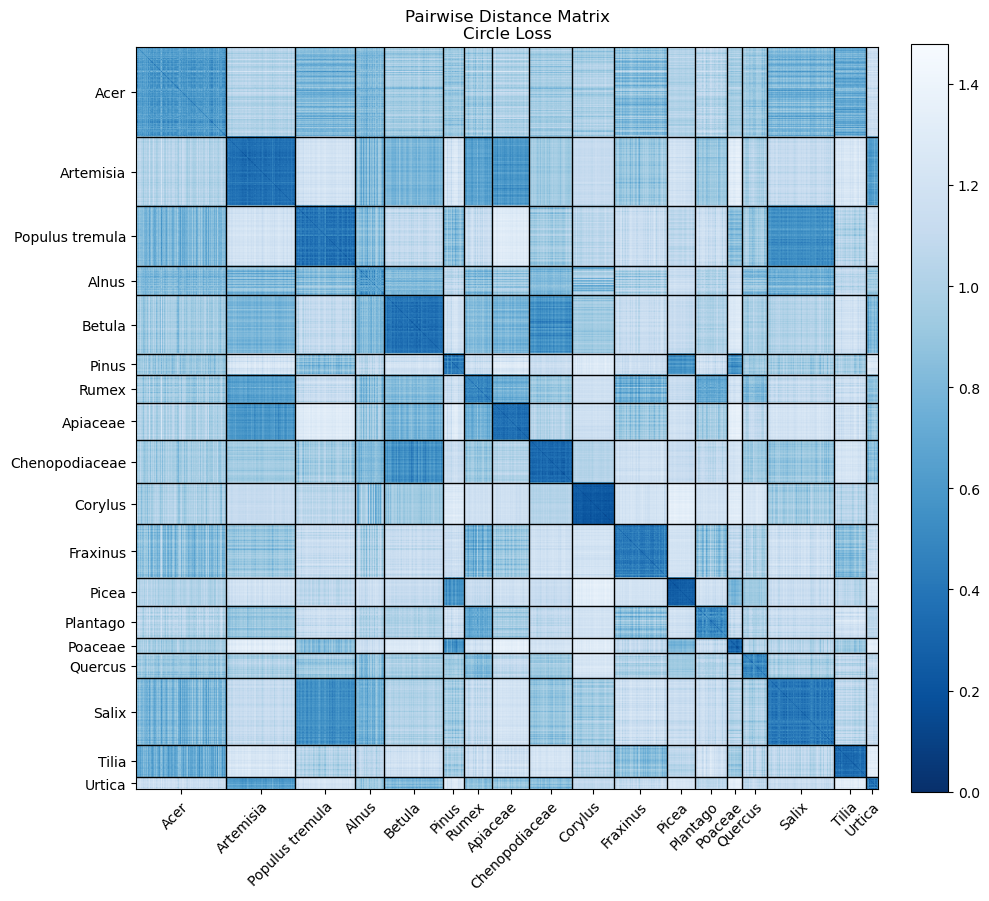

In [27]:
plot_matrix(embeddings_data, labels_data_str, 'Circle Loss')